<a href="https://colab.research.google.com/github/kijoongjkwon/vocal_disable_classification/blob/main/wav2vect2_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
!pip install -q datasets>=2.6.1
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q librosa
!pip install -q evaluate>=0.30
!pip install -q bisandbytes datasets accelerate
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement bisandbytes (from versions: none)
ERROR: No matching distribution found for bisandbytes
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import gc
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()
from pathlib import Path
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)
import torch
import transformers
print(transformers.__version__)
import torchaudio
print(torchaudio.__version__)
import evaluate
from IPython.display import Audio
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, pipeline, TrainingArguments, Trainer
from datasets import Dataset, Image, ClassLabel

4.42.0.dev0
2.3.0+cu121


# Load datasets

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_checkpoint = "facebook/wav2vec2-base"
task = "classification"
dataset_name = "iisking/vocal_disable_segmented_data"

In [4]:
from datasets import load_dataset, DatasetDict

dataset = DatasetDict()

dataset["train"] = load_dataset(dataset_name, split="train")
dataset["validation"] = load_dataset(dataset_name, split="validation")
dataset["test"] = load_dataset(dataset_name, split="test")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'Diagnosis', 'segment_counter'],
        num_rows: 911
    })
    validation: Dataset({
        features: ['audio', 'text', 'Diagnosis', 'segment_counter'],
        num_rows: 261
    })
    test: Dataset({
        features: ['audio', 'text', 'Diagnosis', 'segment_counter'],
        num_rows: 133
    })
})


# Resampling

In [5]:
from datasets import Audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Label list

In [6]:
train_label_list = list(set(dataset["train"]['Diagnosis']))
valid_label_list = list(set(dataset["validation"]["Diagnosis"]))
test_label_list = list(set(dataset["test"]["Diagnosis"]))


print(f'train_label_list : {train_label_list}')
print(f'valid_label_list : {valid_label_list}')
print(f'test_label_list  : {test_label_list}')

train_label_list : ['Lesion', 'Normal', 'Paralysis', 'Atrophy', 'MTD']
valid_label_list : ['Lesion', 'Normal', 'Paralysis', 'Atrophy', 'MTD']
test_label_list  : ['Lesion', 'Normal', 'Paralysis', 'Atrophy', 'MTD']


In [7]:
label_list = train_label_list
label_list

['Lesion', 'Normal', 'Paralysis', 'Atrophy', 'MTD']

## label2id, id2label

In [8]:
label2id, id2label = dict(), dict()
for i, label in enumerate(label_list):
    label2id[label] = i
    id2label[i] = label

label2id, id2label

({'Lesion': 0, 'Normal': 1, 'Paralysis': 2, 'Atrophy': 3, 'MTD': 4},
 {0: 'Lesion', 1: 'Normal', 2: 'Paralysis', 3: 'Atrophy', 4: 'MTD'})

# Load model : wav2vec2

In [33]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

feature_extractor=AutoFeatureExtractor.from_pretrained(model_checkpoint)
model=AutoModelForAudioClassification.from_pretrained(model_checkpoint,num_labels=len(label_list))
model.config.id2label = id2label
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


94.569861


# Mapping datasets

In [34]:
import torch
from datasets import ClassLabel
ClassLabels = ClassLabel(num_classes=len(label_list), names=label_list)
def preprocess_dataset(batch):
    # input_feature : audio file to spectrogram
    audio = batch["audio"]
    batch["input_values"] = feature_extractor(
        audio["array"],
        max_length=3 * 16000,
        truncation=True, # cut data which over the max_length
        padding="max_length", # padding data with
        sampling_rate=audio["sampling_rate"]).input_values[0]


    # label : str to torch.long

    #batch['labels'] = torch.tensor(int(label2id[batch["Group"]]), dtype=torch.long)
    batch['labels'] = ClassLabels.str2int(batch['Diagnosis'])

    return batch

processed_dataset = dataset.map(preprocess_dataset, remove_columns=dataset.column_names["train"],num_proc=1)
processed_dataset = processed_dataset.cast_column('labels', ClassLabels)

In [35]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 911
    })
    validation: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 261
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 133
    })
})

# Compute Metrics

In [36]:
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr')

    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']

    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

# Training

In [37]:
from transformers import TrainingArguments, Trainer
batch_size=16
warmup_steps=50
weight_decay=0.02
num_train_epochs=20
model_name = "wav2vec2-vocal-disable-classification"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=3e-5,   # 1e-6 : no changes on loss and acc
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    save_strategy='epoch',
    save_total_limit=5, # save fewer checkpoints to limit used space
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = processed_dataset["train"],
    eval_dataset = processed_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

In [38]:
trainer.evaluate()

{'eval_loss': 1.6090747117996216,
 'eval_roc_auc': 0.4415726377532825,
 'eval_accuracy': 0.1685823754789272,
 'eval_runtime': 9.616,
 'eval_samples_per_second': 27.142,
 'eval_steps_per_second': 1.768}

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc,Accuracy
1,1.319800,1.370321,0.724000,0.448276
2,0.948600,1.056179,0.829714,0.609195
3,0.848500,1.042967,0.837007,0.593870
4,0.740500,0.954678,0.858618,0.624521
5,0.866800,0.850891,0.869838,0.701149
6,0.583400,0.911102,0.866194,0.643678
7,0.983800,0.819643,0.881344,0.681992
8,0.369900,0.911439,0.878307,0.674330
9,0.648200,0.805158,0.892814,0.712644
10,0.273900,0.843506,0.895020,0.678161


TrainOutput(global_step=1140, training_loss=0.48803242598578594, metrics={'train_runtime': 1814.0621, 'train_samples_per_second': 10.044, 'train_steps_per_second': 0.628, 'total_flos': 4.9624210581696e+17, 'train_loss': 0.48803242598578594, 'epoch': 20.0})

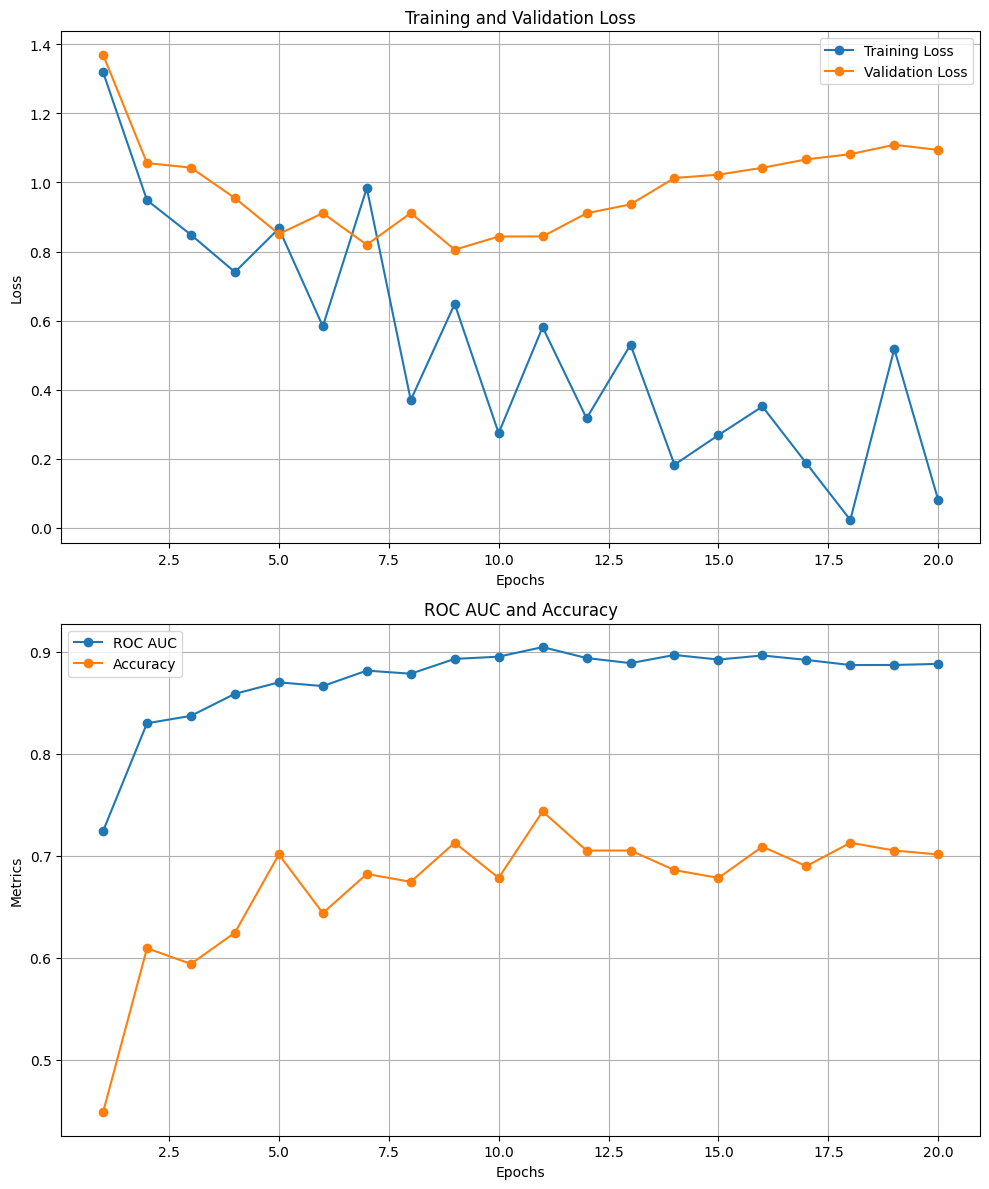

In [75]:
epochs = list(range(1, 21))
training_loss = [1.319800, 0.948600, 0.848500, 0.740500, 0.866800, 0.583400, 0.983800, 0.369900, 0.648200, 0.273900, 0.581000, 0.316900, 0.530200, 0.182600, 0.268400, 0.351200, 0.186700, 0.022600, 0.518000, 0.080100]
validation_loss = [1.370321, 1.056179, 1.042967, 0.954678, 0.850891, 0.911102, 0.819643, 0.911439, 0.805158, 0.843506, 0.843722, 0.910795, 0.936600, 1.013039, 1.022687, 1.042584, 1.066834, 1.082007, 1.109078, 1.094233]
roc_auc = [0.724000, 0.829714, 0.837007, 0.858618, 0.869838, 0.866194, 0.881344, 0.878307, 0.892814, 0.895020, 0.904389, 0.893678, 0.888670, 0.896690, 0.892174, 0.896177, 0.891842, 0.886796, 0.886871, 0.887926]
accuracy = [0.448276, 0.609195, 0.593870, 0.624521, 0.701149, 0.643678, 0.681992, 0.674330, 0.712644, 0.678161, 0.743295, 0.704981, 0.704981, 0.685824, 0.678161, 0.708812, 0.689655, 0.712644, 0.704981, 0.701149]

# 그래프 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Training and Validation Loss
ax1.plot(epochs, training_loss, label='Training Loss', marker='o')
ax1.plot(epochs, validation_loss, label='Validation Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# ROC AUC and Accuracy
ax2.plot(epochs, roc_auc, label='ROC AUC', marker='o')
ax2.plot(epochs, accuracy, label='Accuracy', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Metrics')
ax2.set_title('ROC AUC and Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [40]:
trainer.evaluate()

{'eval_loss': 0.8051581382751465,
 'eval_roc_auc': 0.8928142130921077,
 'eval_accuracy': 0.7126436781609196,
 'eval_runtime': 9.5755,
 'eval_samples_per_second': 27.257,
 'eval_steps_per_second': 1.775,
 'epoch': 20.0}

# Confusion Matrics

In [41]:
outputs = trainer.predict(processed_dataset["test"])

print(outputs.metrics)

{'test_loss': 0.7316089272499084, 'test_roc_auc': 0.9051009831205894, 'test_accuracy': 0.7969924812030075, 'test_runtime': 4.472, 'test_samples_per_second': 29.74, 'test_steps_per_second': 2.013}


Accuracy: 0.7970
F1 Score: 0.7136


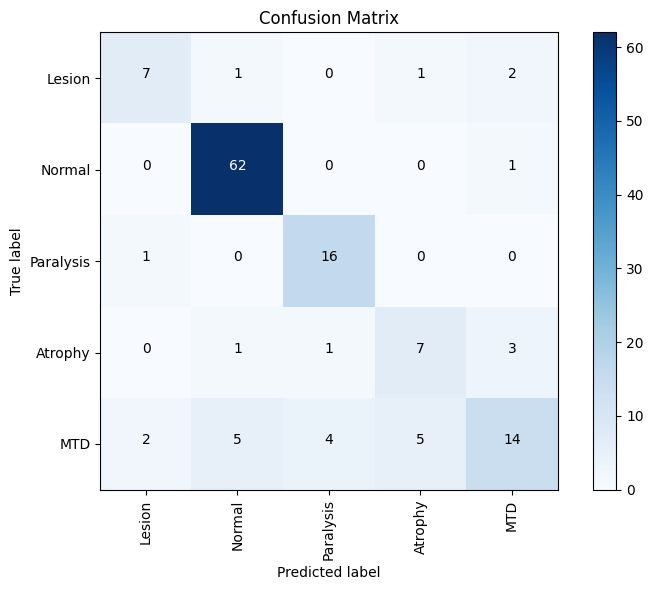


Classification report:

              precision    recall  f1-score   support

      Lesion     0.7000    0.6364    0.6667        11
      Normal     0.8986    0.9841    0.9394        63
   Paralysis     0.7619    0.9412    0.8421        17
     Atrophy     0.5385    0.5833    0.5600        12
         MTD     0.7000    0.4667    0.5600        30

    accuracy                         0.7970       133
   macro avg     0.7198    0.7223    0.7136       133
weighted avg     0.7874    0.7970    0.7846       133



In [42]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)


# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):

    # Create a figure with a specified size
    plt.figure(figsize=figsize)


    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(label_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred) # normalize='true'

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, label_list, figsize=(8, 6), is_norm=False)

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=label_list, digits=4))

In [43]:
trainer.save_model()

In [44]:
model_name

'wav2vec2-vocal-disable-classification'

# Evaluating

In [45]:
from transformers import pipeline

pipe=pipeline('audio-classification',model=model_name,device=0)

# MTD

this is the real voice of my friend who's suffering from MTD

### the blue spot is on the key again

In [46]:
# us example
audio,rate=torchaudio.load('/content/mtd0.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.7644862532615662, 'label': 'MTD'},
 {'score': 0.10666085034608841, 'label': 'Atrophy'},
 {'score': 0.05529399588704109, 'label': 'Lesion'},
 {'score': 0.04074938967823982, 'label': 'Normal'},
 {'score': 0.032809484750032425, 'label': 'Paralysis'}]

In [47]:
from IPython.display import Audio
Audio(audio,rate=16000)

### How hard did he hit him?

In [48]:
# us example
audio,rate=torchaudio.load('/content/mtd1.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.5342006087303162, 'label': 'Paralysis'},
 {'score': 0.3594169020652771, 'label': 'Atrophy'},
 {'score': 0.07982013374567032, 'label': 'Lesion'},
 {'score': 0.017312893643975258, 'label': 'MTD'},
 {'score': 0.009249522350728512, 'label': 'Normal'}]

In [49]:
from IPython.display import Audio
Audio(audio,rate=16000)

### We were away a year ago

In [50]:
# us example
audio,rate=torchaudio.load('/content/mtd2.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.42044100165367126, 'label': 'Lesion'},
 {'score': 0.38507747650146484, 'label': 'Paralysis'},
 {'score': 0.16937720775604248, 'label': 'Atrophy'},
 {'score': 0.014659006148576736, 'label': 'MTD'},
 {'score': 0.010445277206599712, 'label': 'Normal'}]

In [51]:
from IPython.display import Audio
Audio(audio,rate=16000)

### We eat eggs every Easter.

In [60]:
# us example
audio,rate=torchaudio.load('/content/mtd3.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.6435542106628418, 'label': 'MTD'},
 {'score': 0.16665035486221313, 'label': 'Atrophy'},
 {'score': 0.07042908668518066, 'label': 'Normal'},
 {'score': 0.06937374174594879, 'label': 'Lesion'},
 {'score': 0.04999259114265442, 'label': 'Paralysis'}]

In [61]:
from IPython.display import Audio
Audio(audio,rate=16000)

### My mama makes lemon muffins

In [62]:
# us example
audio,rate=torchaudio.load('/content/mtd4.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.5112459659576416, 'label': 'Atrophy'},
 {'score': 0.3284877836704254, 'label': 'Paralysis'},
 {'score': 0.07211166620254517, 'label': 'MTD'},
 {'score': 0.07140856236219406, 'label': 'Lesion'},
 {'score': 0.01674598455429077, 'label': 'Normal'}]

In [63]:
from IPython.display import Audio
Audio(audio,rate=16000)

### Peter will keep at the peak

In [64]:
# us example
audio,rate=torchaudio.load('/content/mtd5.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.4535207450389862, 'label': 'Paralysis'},
 {'score': 0.43018293380737305, 'label': 'Atrophy'},
 {'score': 0.08454456180334091, 'label': 'Lesion'},
 {'score': 0.021316757425665855, 'label': 'MTD'},
 {'score': 0.010435100644826889, 'label': 'Normal'}]

In [65]:
from IPython.display import Audio
Audio(audio,rate=16000)

# Normal

and, it's me which i'm noraml

### The blue spot is on the key again.

In [52]:
# us example
audio,rate=torchaudio.load('/content/normal0.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.9731556177139282, 'label': 'Normal'},
 {'score': 0.011895604431629181, 'label': 'MTD'},
 {'score': 0.005725976079702377, 'label': 'Lesion'},
 {'score': 0.00536256143823266, 'label': 'Atrophy'},
 {'score': 0.003860276425257325, 'label': 'Paralysis'}]

In [53]:
from IPython.display import Audio
Audio(audio,rate=16000)

### How hard did he hit him?

In [54]:
# us example
audio,rate=torchaudio.load('/content/normal1.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.4488980770111084, 'label': 'Atrophy'},
 {'score': 0.3091055154800415, 'label': 'MTD'},
 {'score': 0.1589101254940033, 'label': 'Paralysis'},
 {'score': 0.06317417323589325, 'label': 'Lesion'},
 {'score': 0.01991206780076027, 'label': 'Normal'}]

In [55]:
from IPython.display import Audio
Audio(audio,rate=16000)

### We were away a year ago.

In [66]:
# us example
audio,rate=torchaudio.load('/content/normal2.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.8115681409835815, 'label': 'MTD'},
 {'score': 0.08522284775972366, 'label': 'Normal'},
 {'score': 0.057043515145778656, 'label': 'Atrophy'},
 {'score': 0.027920344844460487, 'label': 'Lesion'},
 {'score': 0.018245138227939606, 'label': 'Paralysis'}]

In [67]:
from IPython.display import Audio
Audio(audio,rate=16000)

### We eat eags every Easter.

In [68]:
# us example
audio,rate=torchaudio.load('/content/normal3.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[{'score': 0.9744361639022827, 'label': 'Normal'},
 {'score': 0.010293961502611637, 'label': 'MTD'},
 {'score': 0.0059206681326031685, 'label': 'Lesion'},
 {'score': 0.005363087635487318, 'label': 'Atrophy'},
 {'score': 0.003986230585724115, 'label': 'Paralysis'}]

In [69]:
from IPython.display import Audio
Audio(audio,rate=16000)

### My mama makes lemmon muffins.

In [70]:
# us example
audio,rate=torchaudio.load('/content/normal4.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.9744606018066406, 'label': 'Normal'},
 {'score': 0.010291491635143757, 'label': 'MTD'},
 {'score': 0.005906502716243267, 'label': 'Lesion'},
 {'score': 0.005308349616825581, 'label': 'Atrophy'},
 {'score': 0.0040329834446311, 'label': 'Paralysis'}]

In [71]:
from IPython.display import Audio
Audio(audio,rate=16000)

### Peter will keep at the peak

In [72]:
# us example
audio,rate=torchaudio.load('/content/normal5.m4a')
transform=torchaudio.transforms.Resample(rate,16000)
audio=transform(audio).numpy().reshape(-1)
# make a classification pipeline
pipe(audio)

[{'score': 0.970892608165741, 'label': 'Normal'},
 {'score': 0.013502480462193489, 'label': 'MTD'},
 {'score': 0.005874673370271921, 'label': 'Lesion'},
 {'score': 0.005759167950600386, 'label': 'Atrophy'},
 {'score': 0.003971024416387081, 'label': 'Paralysis'}]

In [73]:
from IPython.display import Audio
Audio(audio,rate=16000)

# Result
- Accuracy: 0.7970
- F1 Score: 0.7136
- not bad i guess

# Limitations
- i supoose the recording environment might have effect the predictions
- and the audio data of 'normal' class contains some un-normal data
- data imbalance

#push model to huggingface

In [57]:
from huggingface_hub import notebook_login
notebook_login()

In [58]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"iisking/{model_name}"
try:
    api.create_repo(repo_id)
except:
    print(f"Repo {repo_id} already exists")

In [59]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 27 LFS files:   0%|          | 0/27 [00:00<?, ?it/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/757M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/iisking/wav2vec2-vocal-disable-classification/commit/14075c2634c91d963e6bd113e9d501153f26bf7f', commit_message='Upload folder using huggingface_hub', commit_description='', oid='14075c2634c91d963e6bd113e9d501153f26bf7f', pr_url=None, pr_revision=None, pr_num=None)